# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11281
EM converged at iteration 32, llf=-11054, convergence criterion=9.8766e-07 < tolerance=1e-06
EM start iterations, llf=-11294
EM converged at iteration 32, llf=-11066, convergence criterion=9.8758e-07 < tolerance=1e-06
EM start iterations, llf=-11347
EM converged at iteration 32, llf=-11116, convergence criterion=9.8984e-07 < tolerance=1e-06
EM start iterations, llf=-11354
EM converged at iteration 32, llf=-11123, convergence criterion=9.9183e-07 < tolerance=1e-06
EM start iterations, llf=-11426
EM converged at iteration 32, llf=-11191, convergence criterion=9.5694e-07 < tolerance=1e-06
EM start iterations, llf=-11435
EM converged at iteration 32, llf=-11198, convergence criterion=9.437e-07 < tolerance=1e-06
EM start iterations, llf=-11491
EM converged at iteration 32, llf=-11254, convergence criterion=9.8481e-07 < tolerance=1e-06
EM start iterations, llf=-11491
EM converged at iteration 32, llf=-11254, convergence criterion=9.8481e-07 < tolerance=1e-06
E

EM start iterations, llf=-12818
EM converged at iteration 26, llf=-12631, convergence criterion=9.2247e-07 < tolerance=1e-06
EM start iterations, llf=-12883
EM converged at iteration 25, llf=-12705, convergence criterion=8.8233e-07 < tolerance=1e-06
EM start iterations, llf=-12889
EM converged at iteration 27, llf=-12709, convergence criterion=9.4381e-07 < tolerance=1e-06
EM start iterations, llf=-12940
EM converged at iteration 28, llf=-12755, convergence criterion=9.3454e-07 < tolerance=1e-06
EM start iterations, llf=-12940
EM converged at iteration 28, llf=-12755, convergence criterion=9.3454e-07 < tolerance=1e-06
EM start iterations, llf=-12952
EM converged at iteration 29, llf=-12768, convergence criterion=9.6987e-07 < tolerance=1e-06
EM start iterations, llf=-13002
EM converged at iteration 29, llf=-12820, convergence criterion=9.3116e-07 < tolerance=1e-06
EM start iterations, llf=-13007
EM converged at iteration 30, llf=-12824, convergence criterion=8.8399e-07 < tolerance=1e-06


EM start iterations, llf=-14468
EM converged at iteration 30, llf=-14270, convergence criterion=9.6779e-07 < tolerance=1e-06
EM start iterations, llf=-14468
EM converged at iteration 30, llf=-14270, convergence criterion=9.6779e-07 < tolerance=1e-06
EM start iterations, llf=-14478
EM converged at iteration 30, llf=-14279, convergence criterion=9.6702e-07 < tolerance=1e-06
EM start iterations, llf=-14529
EM converged at iteration 30, llf=-14331, convergence criterion=9.4377e-07 < tolerance=1e-06
EM start iterations, llf=-14540
EM converged at iteration 30, llf=-14342, convergence criterion=9.2923e-07 < tolerance=1e-06
EM start iterations, llf=-14588
EM converged at iteration 30, llf=-14389, convergence criterion=9.1355e-07 < tolerance=1e-06
EM start iterations, llf=-14596
EM converged at iteration 30, llf=-14396, convergence criterion=8.8428e-07 < tolerance=1e-06
EM start iterations, llf=-14642
EM converged at iteration 30, llf=-14441, convergence criterion=8.5967e-07 < tolerance=1e-06


EM start iterations, llf=-16158
EM converged at iteration 28, llf=-15925, convergence criterion=9.5637e-07 < tolerance=1e-06
EM start iterations, llf=-16162
EM converged at iteration 28, llf=-15930, convergence criterion=9.5881e-07 < tolerance=1e-06
EM start iterations, llf=-16214
EM converged at iteration 28, llf=-15982, convergence criterion=9.2921e-07 < tolerance=1e-06
EM start iterations, llf=-16221
EM converged at iteration 28, llf=-15988, convergence criterion=9.4003e-07 < tolerance=1e-06
EM start iterations, llf=-16276
EM converged at iteration 28, llf=-16043, convergence criterion=9.3137e-07 < tolerance=1e-06
EM start iterations, llf=-16276
EM converged at iteration 28, llf=-16043, convergence criterion=9.3137e-07 < tolerance=1e-06
EM start iterations, llf=-16285
EM converged at iteration 28, llf=-16052, convergence criterion=9.1136e-07 < tolerance=1e-06
EM start iterations, llf=-16333
EM converged at iteration 28, llf=-16101, convergence criterion=8.5792e-07 < tolerance=1e-06


EM start iterations, llf=-17619
EM converged at iteration 24, llf=-17375, convergence criterion=9.5459e-07 < tolerance=1e-06
EM start iterations, llf=-17674
EM converged at iteration 24, llf=-17429, convergence criterion=9.5488e-07 < tolerance=1e-06
EM start iterations, llf=-17674
EM converged at iteration 24, llf=-17429, convergence criterion=9.5488e-07 < tolerance=1e-06
EM start iterations, llf=-17679
EM converged at iteration 24, llf=-17434, convergence criterion=9.5558e-07 < tolerance=1e-06
EM start iterations, llf=-17730
EM converged at iteration 25, llf=-17484, convergence criterion=8.3237e-07 < tolerance=1e-06
EM start iterations, llf=-17737
EM converged at iteration 25, llf=-17491, convergence criterion=8.3318e-07 < tolerance=1e-06
EM start iterations, llf=-17791
EM converged at iteration 24, llf=-17543, convergence criterion=9.9361e-07 < tolerance=1e-06
EM start iterations, llf=-17798
EM converged at iteration 25, llf=-17551, convergence criterion=8.3182e-07 < tolerance=1e-06


EM start iterations, llf=-11866
EM converged at iteration 42, llf=-11606, convergence criterion=9.9349e-07 < tolerance=1e-06
EM start iterations, llf=-11849
EM converged at iteration 42, llf=-11586, convergence criterion=9.5555e-07 < tolerance=1e-06
EM start iterations, llf=-11960
EM converged at iteration 42, llf=-11698, convergence criterion=9.5439e-07 < tolerance=1e-06
EM start iterations, llf=-11979
EM converged at iteration 42, llf=-11723, convergence criterion=9.6485e-07 < tolerance=1e-06
EM start iterations, llf=-11976
EM converged at iteration 45, llf=-11744, convergence criterion=9.6228e-07 < tolerance=1e-06
EM start iterations, llf=-11975
EM converged at iteration 44, llf=-11742, convergence criterion=9.9528e-07 < tolerance=1e-06
EM start iterations, llf=-11949
EM converged at iteration 42, llf=-11723, convergence criterion=9.6561e-07 < tolerance=1e-06
EM start iterations, llf=-11949
EM converged at iteration 42, llf=-11723, convergence criterion=9.6561e-07 < tolerance=1e-06


EM start iterations, llf=-13331
EM converged at iteration 42, llf=-13135, convergence criterion=9.9113e-07 < tolerance=1e-06
EM start iterations, llf=-13359
EM converged at iteration 41, llf=-13155, convergence criterion=9.726e-07 < tolerance=1e-06
EM start iterations, llf=-13364
EM converged at iteration 43, llf=-13168, convergence criterion=9.5136e-07 < tolerance=1e-06
EM start iterations, llf=-13402
EM converged at iteration 46, llf=-13214, convergence criterion=9.6851e-07 < tolerance=1e-06
EM start iterations, llf=-13402
EM converged at iteration 46, llf=-13214, convergence criterion=9.6851e-07 < tolerance=1e-06
EM start iterations, llf=-13413
EM converged at iteration 46, llf=-13225, convergence criterion=9.7008e-07 < tolerance=1e-06
EM start iterations, llf=-13458
EM converged at iteration 45, llf=-13269, convergence criterion=9.9256e-07 < tolerance=1e-06
EM start iterations, llf=-13466
EM converged at iteration 45, llf=-13275, convergence criterion=9.5651e-07 < tolerance=1e-06
E

EM start iterations, llf=-15011
EM converged at iteration 38, llf=-14796, convergence criterion=9.9454e-07 < tolerance=1e-06
EM start iterations, llf=-15011
EM converged at iteration 38, llf=-14796, convergence criterion=9.9454e-07 < tolerance=1e-06
EM start iterations, llf=-15019
EM converged at iteration 38, llf=-14804, convergence criterion=9.674e-07 < tolerance=1e-06
EM start iterations, llf=-15070
EM converged at iteration 38, llf=-14852, convergence criterion=9.6743e-07 < tolerance=1e-06
EM start iterations, llf=-15072
EM converged at iteration 38, llf=-14854, convergence criterion=9.8092e-07 < tolerance=1e-06
EM start iterations, llf=-15126
EM converged at iteration 39, llf=-14907, convergence criterion=9.5914e-07 < tolerance=1e-06
EM start iterations, llf=-15131
EM converged at iteration 39, llf=-14911, convergence criterion=9.5402e-07 < tolerance=1e-06
EM start iterations, llf=-15174
EM converged at iteration 39, llf=-14954, convergence criterion=9.6232e-07 < tolerance=1e-06
E

EM start iterations, llf=-16699
EM converged at iteration 34, llf=-16469, convergence criterion=9.4394e-07 < tolerance=1e-06
EM start iterations, llf=-16704
EM converged at iteration 34, llf=-16474, convergence criterion=9.4289e-07 < tolerance=1e-06
EM start iterations, llf=-16757
EM converged at iteration 33, llf=-16525, convergence criterion=9.9149e-07 < tolerance=1e-06
EM start iterations, llf=-16765
EM converged at iteration 33, llf=-16532, convergence criterion=9.8818e-07 < tolerance=1e-06
EM start iterations, llf=-16809
EM converged at iteration 33, llf=-16576, convergence criterion=9.8131e-07 < tolerance=1e-06
EM start iterations, llf=-16809
EM converged at iteration 33, llf=-16576, convergence criterion=9.8131e-07 < tolerance=1e-06
EM start iterations, llf=-16829
EM converged at iteration 33, llf=-16596, convergence criterion=9.9076e-07 < tolerance=1e-06
EM start iterations, llf=-16879
EM converged at iteration 32, llf=-16646, convergence criterion=9.9122e-07 < tolerance=1e-06


EM start iterations, llf=-18145
EM converged at iteration 33, llf=-17884, convergence criterion=9.5339e-07 < tolerance=1e-06
EM start iterations, llf=-18192
EM converged at iteration 32, llf=-17932, convergence criterion=9.8685e-07 < tolerance=1e-06
EM start iterations, llf=-18192
EM converged at iteration 32, llf=-17932, convergence criterion=9.8685e-07 < tolerance=1e-06
EM start iterations, llf=-18199
EM converged at iteration 32, llf=-17941, convergence criterion=9.8388e-07 < tolerance=1e-06
EM start iterations, llf=-18254
EM converged at iteration 32, llf=-17996, convergence criterion=9.829e-07 < tolerance=1e-06
EM start iterations, llf=-18262
EM converged at iteration 32, llf=-18003, convergence criterion=9.813e-07 < tolerance=1e-06
EM start iterations, llf=-18313
EM converged at iteration 32, llf=-18053, convergence criterion=9.8222e-07 < tolerance=1e-06
EM start iterations, llf=-18321
EM converged at iteration 32, llf=-18061, convergence criterion=9.8154e-07 < tolerance=1e-06
EM

EM start iterations, llf=-12153
EM converged at iteration 42, llf=-11944, convergence criterion=9.7486e-07 < tolerance=1e-06
EM start iterations, llf=-12158
EM converged at iteration 42, llf=-11950, convergence criterion=9.7369e-07 < tolerance=1e-06
EM start iterations, llf=-12201
EM converged at iteration 42, llf=-11990, convergence criterion=9.4241e-07 < tolerance=1e-06
EM start iterations, llf=-12208
EM converged at iteration 42, llf=-11997, convergence criterion=9.4531e-07 < tolerance=1e-06
EM start iterations, llf=-12255
EM converged at iteration 41, llf=-12039, convergence criterion=9.621e-07 < tolerance=1e-06
EM start iterations, llf=-12265
EM converged at iteration 41, llf=-12049, convergence criterion=9.4801e-07 < tolerance=1e-06
EM start iterations, llf=-12322
EM converged at iteration 43, llf=-12112, convergence criterion=9.4323e-07 < tolerance=1e-06
EM start iterations, llf=-12322
EM converged at iteration 43, llf=-12112, convergence criterion=9.4323e-07 < tolerance=1e-06
E

EM start iterations, llf=-13810
EM converged at iteration 45, llf=-13616, convergence criterion=9.754e-07 < tolerance=1e-06
EM start iterations, llf=-13862
EM converged at iteration 46, llf=-13671, convergence criterion=9.9286e-07 < tolerance=1e-06
EM start iterations, llf=-13870
EM converged at iteration 46, llf=-13676, convergence criterion=9.534e-07 < tolerance=1e-06
EM start iterations, llf=-13921
EM converged at iteration 47, llf=-13729, convergence criterion=9.547e-07 < tolerance=1e-06
EM start iterations, llf=-13921
EM converged at iteration 47, llf=-13729, convergence criterion=9.547e-07 < tolerance=1e-06
EM start iterations, llf=-13929
EM converged at iteration 46, llf=-13736, convergence criterion=9.7992e-07 < tolerance=1e-06
EM start iterations, llf=-13983
EM converged at iteration 46, llf=-13789, convergence criterion=9.6095e-07 < tolerance=1e-06
EM start iterations, llf=-13992
EM converged at iteration 45, llf=-13796, convergence criterion=9.63e-07 < tolerance=1e-06
EM sta

EM start iterations, llf=-15538
EM converged at iteration 43, llf=-15317, convergence criterion=9.5242e-07 < tolerance=1e-06
EM start iterations, llf=-15538
EM converged at iteration 43, llf=-15317, convergence criterion=9.5242e-07 < tolerance=1e-06
EM start iterations, llf=-15547
EM converged at iteration 43, llf=-15325, convergence criterion=9.5383e-07 < tolerance=1e-06
EM start iterations, llf=-15596
EM converged at iteration 43, llf=-15373, convergence criterion=9.4036e-07 < tolerance=1e-06
EM start iterations, llf=-15605
EM converged at iteration 42, llf=-15382, convergence criterion=9.9767e-07 < tolerance=1e-06
EM start iterations, llf=-15655
EM converged at iteration 42, llf=-15431, convergence criterion=9.8347e-07 < tolerance=1e-06
EM start iterations, llf=-15662
EM converged at iteration 42, llf=-15438, convergence criterion=9.7975e-07 < tolerance=1e-06
EM start iterations, llf=-15713
EM converged at iteration 42, llf=-15488, convergence criterion=9.7473e-07 < tolerance=1e-06


EM start iterations, llf=-17216
EM converged at iteration 37, llf=-16977, convergence criterion=9.8727e-07 < tolerance=1e-06
EM start iterations, llf=-17222
EM converged at iteration 37, llf=-16985, convergence criterion=9.8226e-07 < tolerance=1e-06
EM start iterations, llf=-17271
EM converged at iteration 37, llf=-17032, convergence criterion=9.8002e-07 < tolerance=1e-06
EM start iterations, llf=-17278
EM converged at iteration 37, llf=-17040, convergence criterion=9.8127e-07 < tolerance=1e-06
EM start iterations, llf=-17332
EM converged at iteration 37, llf=-17093, convergence criterion=9.8887e-07 < tolerance=1e-06
EM start iterations, llf=-17332
EM converged at iteration 37, llf=-17093, convergence criterion=9.8887e-07 < tolerance=1e-06
EM start iterations, llf=-17336
EM converged at iteration 37, llf=-17095, convergence criterion=9.9054e-07 < tolerance=1e-06
EM start iterations, llf=-17389
EM converged at iteration 37, llf=-17147, convergence criterion=9.82e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18382
EM converged at iteration 38, llf=-18116, convergence criterion=9.4273e-07 < tolerance=1e-06
EM start iterations, llf=-18435
EM converged at iteration 38, llf=-18169, convergence criterion=9.3952e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:27:32.651798.
EM start iterations, llf=-10802
EM converged at iteration 25, llf=-10671, convergence criterion=9.6176e-07 < tolerance=1e-06
EM start iterations, llf=-10815
EM converged at iteration 25, llf=-10684, convergence criterion=9.6525e-07 < tolerance=1e-06
EM start iterations, llf=-10867
EM converged at iteration 24, llf=-10736, convergence criterion=9.8278e-07 < tolerance=1e-06
EM start iterations, llf=-10875
EM converged at iteration 24, llf=-10744, convergence criterion=9.8927e-07 < tolerance=1e-06
EM start iterations, llf=-10940
EM converged at iteration 21, llf=-10810, convergence criterion=9.8892e-07 < tolerance=1e-06
EM start iterations, llf=-10951
EM converged at

EM start iterations, llf=-12101
EM converged at iteration 23, llf=-11957, convergence criterion=9.3638e-07 < tolerance=1e-06
EM start iterations, llf=-12114
EM converged at iteration 23, llf=-11969, convergence criterion=9.4723e-07 < tolerance=1e-06
EM start iterations, llf=-12147
EM converged at iteration 23, llf=-12002, convergence criterion=9.5828e-07 < tolerance=1e-06
EM start iterations, llf=-12154
EM converged at iteration 23, llf=-12006, convergence criterion=9.796e-07 < tolerance=1e-06
EM start iterations, llf=-12216
EM converged at iteration 23, llf=-12062, convergence criterion=9.624e-07 < tolerance=1e-06
EM start iterations, llf=-12221
EM converged at iteration 23, llf=-12070, convergence criterion=9.3892e-07 < tolerance=1e-06
EM start iterations, llf=-12262
EM converged at iteration 22, llf=-12110, convergence criterion=9.5925e-07 < tolerance=1e-06
EM start iterations, llf=-12262
EM converged at iteration 22, llf=-12110, convergence criterion=9.5925e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13632
EM converged at iteration 19, llf=-13476, convergence criterion=9.1153e-07 < tolerance=1e-06
EM start iterations, llf=-13672
EM converged at iteration 19, llf=-13517, convergence criterion=9.0986e-07 < tolerance=1e-06
EM start iterations, llf=-13680
EM converged at iteration 18, llf=-13525, convergence criterion=9.973e-07 < tolerance=1e-06
EM start iterations, llf=-13736
EM converged at iteration 18, llf=-13577, convergence criterion=9.6827e-07 < tolerance=1e-06
EM start iterations, llf=-13736
EM converged at iteration 18, llf=-13577, convergence criterion=9.6827e-07 < tolerance=1e-06
EM start iterations, llf=-13743
EM converged at iteration 18, llf=-13585, convergence criterion=9.7453e-07 < tolerance=1e-06
EM start iterations, llf=-13793
EM converged at iteration 18, llf=-13634, convergence criterion=9.5361e-07 < tolerance=1e-06
EM start iterations, llf=-13800
EM converged at iteration 18, llf=-13642, convergence criterion=9.3824e-07 < tolerance=1e-06
E

EM start iterations, llf=-15300
EM converged at iteration 19, llf=-15132, convergence criterion=9.1037e-07 < tolerance=1e-06
EM start iterations, llf=-15300
EM converged at iteration 19, llf=-15132, convergence criterion=9.1037e-07 < tolerance=1e-06
EM start iterations, llf=-15313
EM converged at iteration 18, llf=-15146, convergence criterion=9.9762e-07 < tolerance=1e-06
EM start iterations, llf=-15368
EM converged at iteration 19, llf=-15201, convergence criterion=9.4045e-07 < tolerance=1e-06
EM start iterations, llf=-15371
EM converged at iteration 19, llf=-15204, convergence criterion=9.5926e-07 < tolerance=1e-06
EM start iterations, llf=-15422
EM converged at iteration 19, llf=-15255, convergence criterion=9.4992e-07 < tolerance=1e-06
EM start iterations, llf=-15429
EM converged at iteration 19, llf=-15262, convergence criterion=9.5437e-07 < tolerance=1e-06
EM start iterations, llf=-15480
EM converged at iteration 19, llf=-15313, convergence criterion=9.7835e-07 < tolerance=1e-06


EM start iterations, llf=-16691
EM converged at iteration 19, llf=-16521, convergence criterion=9.3612e-07 < tolerance=1e-06
EM start iterations, llf=-16705
EM converged at iteration 19, llf=-16534, convergence criterion=9.2696e-07 < tolerance=1e-06
EM start iterations, llf=-16758
EM converged at iteration 19, llf=-16586, convergence criterion=9.1234e-07 < tolerance=1e-06
EM start iterations, llf=-16764
EM converged at iteration 19, llf=-16592, convergence criterion=9.1275e-07 < tolerance=1e-06
EM start iterations, llf=-16815
EM converged at iteration 18, llf=-16643, convergence criterion=9.7285e-07 < tolerance=1e-06
EM start iterations, llf=-16815
EM converged at iteration 18, llf=-16643, convergence criterion=9.7285e-07 < tolerance=1e-06
EM start iterations, llf=-16821
EM converged at iteration 18, llf=-16649, convergence criterion=9.8555e-07 < tolerance=1e-06
EM start iterations, llf=-16869
EM converged at iteration 18, llf=-16696, convergence criterion=9.7159e-07 < tolerance=1e-06


EM start iterations, llf=-11274
EM converged at iteration 50, llf=-11132, convergence criterion=9.8222e-07 < tolerance=1e-06
EM start iterations, llf=-11277
EM converged at iteration 50, llf=-11134, convergence criterion=9.8282e-07 < tolerance=1e-06
EM start iterations, llf=-11351
EM converged at iteration 44, llf=-11207, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-11351
EM converged at iteration 44, llf=-11207, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-11363
EM converged at iteration 44, llf=-11221, convergence criterion=9.7633e-07 < tolerance=1e-06
EM start iterations, llf=-11487
EM converged at iteration 39, llf=-11339, convergence criterion=9.9581e-07 < tolerance=1e-06
EM start iterations, llf=-11473
EM converged at iteration 42, llf=-11324, convergence criterion=9.9148e-07 < tolerance=1e-06
EM start iterations, llf=-11426
EM converged at iteration 38, llf=-11272, convergence criterion=9.9163e-07 < tolerance=1e-06


EM start iterations, llf=-12579
EM converged at iteration 34, llf=-12421, convergence criterion=9.946e-07 < tolerance=1e-06
EM start iterations, llf=-12588
EM converged at iteration 34, llf=-12432, convergence criterion=9.8448e-07 < tolerance=1e-06
EM start iterations, llf=-12624
EM converged at iteration 35, llf=-12468, convergence criterion=9.7077e-07 < tolerance=1e-06
EM start iterations, llf=-12633
EM converged at iteration 35, llf=-12477, convergence criterion=9.9693e-07 < tolerance=1e-06
EM start iterations, llf=-12667
EM converged at iteration 35, llf=-12510, convergence criterion=9.9448e-07 < tolerance=1e-06
EM start iterations, llf=-12660
EM converged at iteration 34, llf=-12507, convergence criterion=9.8731e-07 < tolerance=1e-06
EM start iterations, llf=-12693
EM converged at iteration 34, llf=-12539, convergence criterion=9.7316e-07 < tolerance=1e-06
EM start iterations, llf=-12693
EM converged at iteration 34, llf=-12539, convergence criterion=9.7316e-07 < tolerance=1e-06
E

EM start iterations, llf=-14144
EM converged at iteration 25, llf=-13983, convergence criterion=9.8738e-07 < tolerance=1e-06
EM start iterations, llf=-14198
EM converged at iteration 25, llf=-14037, convergence criterion=9.9318e-07 < tolerance=1e-06
EM start iterations, llf=-14205
EM converged at iteration 25, llf=-14043, convergence criterion=9.9727e-07 < tolerance=1e-06
EM start iterations, llf=-14248
EM converged at iteration 25, llf=-14089, convergence criterion=9.5355e-07 < tolerance=1e-06
EM start iterations, llf=-14248
EM converged at iteration 25, llf=-14089, convergence criterion=9.5355e-07 < tolerance=1e-06
EM start iterations, llf=-14261
EM converged at iteration 24, llf=-14100, convergence criterion=9.9423e-07 < tolerance=1e-06
EM start iterations, llf=-14314
EM converged at iteration 25, llf=-14151, convergence criterion=9.5311e-07 < tolerance=1e-06
EM start iterations, llf=-14313
EM converged at iteration 25, llf=-14152, convergence criterion=9.6748e-07 < tolerance=1e-06


EM start iterations, llf=-15814
EM converged at iteration 23, llf=-15642, convergence criterion=9.7902e-07 < tolerance=1e-06
EM start iterations, llf=-15814
EM converged at iteration 23, llf=-15642, convergence criterion=9.7902e-07 < tolerance=1e-06
EM start iterations, llf=-15823
EM converged at iteration 23, llf=-15650, convergence criterion=9.7633e-07 < tolerance=1e-06
EM start iterations, llf=-15868
EM converged at iteration 23, llf=-15694, convergence criterion=9.6552e-07 < tolerance=1e-06
EM start iterations, llf=-15872
EM converged at iteration 23, llf=-15699, convergence criterion=9.6215e-07 < tolerance=1e-06
EM start iterations, llf=-15924
EM converged at iteration 23, llf=-15751, convergence criterion=9.517e-07 < tolerance=1e-06
EM start iterations, llf=-15933
EM converged at iteration 23, llf=-15761, convergence criterion=9.6427e-07 < tolerance=1e-06
EM start iterations, llf=-15974
EM converged at iteration 23, llf=-15802, convergence criterion=9.7464e-07 < tolerance=1e-06
E

EM start iterations, llf=-17202
EM converged at iteration 24, llf=-17025, convergence criterion=9.6028e-07 < tolerance=1e-06
EM start iterations, llf=-17210
EM converged at iteration 24, llf=-17032, convergence criterion=9.5514e-07 < tolerance=1e-06
EM start iterations, llf=-17255
EM converged at iteration 24, llf=-17078, convergence criterion=9.3682e-07 < tolerance=1e-06
EM start iterations, llf=-17262
EM converged at iteration 23, llf=-17085, convergence criterion=9.9638e-07 < tolerance=1e-06
EM start iterations, llf=-17305
EM converged at iteration 23, llf=-17127, convergence criterion=9.9201e-07 < tolerance=1e-06
EM start iterations, llf=-17305
EM converged at iteration 23, llf=-17127, convergence criterion=9.9201e-07 < tolerance=1e-06
EM start iterations, llf=-17310
EM converged at iteration 23, llf=-17132, convergence criterion=9.9368e-07 < tolerance=1e-06
EM start iterations, llf=-17363
EM converged at iteration 23, llf=-17185, convergence criterion=9.9399e-07 < tolerance=1e-06


EM start iterations, llf=-11493
EM converged at iteration 48, llf=-11347, convergence criterion=9.8596e-07 < tolerance=1e-06
EM start iterations, llf=-11509
EM converged at iteration 47, llf=-11358, convergence criterion=9.7365e-07 < tolerance=1e-06
EM start iterations, llf=-11566
EM converged at iteration 47, llf=-11412, convergence criterion=9.9293e-07 < tolerance=1e-06
EM start iterations, llf=-11566
EM converged at iteration 47, llf=-11412, convergence criterion=9.9293e-07 < tolerance=1e-06
EM start iterations, llf=-11567
EM converged at iteration 50, llf=-11416, convergence criterion=9.9136e-07 < tolerance=1e-06
EM start iterations, llf=-11600
EM converged at iteration 53, llf=-11452, convergence criterion=9.923e-07 < tolerance=1e-06
EM start iterations, llf=-11611
EM converged at iteration 51, llf=-11461, convergence criterion=9.8998e-07 < tolerance=1e-06
EM start iterations, llf=-11658
EM converged at iteration 53, llf=-11511, convergence criterion=9.9566e-07 < tolerance=1e-06
E

EM start iterations, llf=-13023
EM converged at iteration 50, llf=-12865, convergence criterion=9.9778e-07 < tolerance=1e-06
EM start iterations, llf=-13029
EM converged at iteration 50, llf=-12871, convergence criterion=9.9802e-07 < tolerance=1e-06
EM start iterations, llf=-13087
EM converged at iteration 49, llf=-12929, convergence criterion=9.76e-07 < tolerance=1e-06
EM start iterations, llf=-13093
EM converged at iteration 48, llf=-12935, convergence criterion=9.8452e-07 < tolerance=1e-06
EM start iterations, llf=-13141
EM converged at iteration 48, llf=-12983, convergence criterion=9.913e-07 < tolerance=1e-06
EM start iterations, llf=-13149
EM converged at iteration 47, llf=-12993, convergence criterion=9.9164e-07 < tolerance=1e-06
EM start iterations, llf=-13200
EM converged at iteration 46, llf=-13041, convergence criterion=9.7207e-07 < tolerance=1e-06
EM start iterations, llf=-13200
EM converged at iteration 46, llf=-13041, convergence criterion=9.7207e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14653
EM converged at iteration 41, llf=-14487, convergence criterion=9.8249e-07 < tolerance=1e-06
EM start iterations, llf=-14707
EM converged at iteration 41, llf=-14540, convergence criterion=9.8087e-07 < tolerance=1e-06
EM start iterations, llf=-14712
EM converged at iteration 41, llf=-14545, convergence criterion=9.8529e-07 < tolerance=1e-06
EM start iterations, llf=-14766
EM converged at iteration 42, llf=-14598, convergence criterion=9.7858e-07 < tolerance=1e-06
EM start iterations, llf=-14766
EM converged at iteration 42, llf=-14598, convergence criterion=9.7858e-07 < tolerance=1e-06
EM start iterations, llf=-14776
EM converged at iteration 42, llf=-14608, convergence criterion=9.7151e-07 < tolerance=1e-06
EM start iterations, llf=-14823
EM converged at iteration 42, llf=-14655, convergence criterion=9.6471e-07 < tolerance=1e-06
EM start iterations, llf=-14832
EM converged at iteration 41, llf=-14664, convergence criterion=9.9665e-07 < tolerance=1e-06


EM start iterations, llf=-16324
EM converged at iteration 46, llf=-16148, convergence criterion=9.7916e-07 < tolerance=1e-06
EM start iterations, llf=-16324
EM converged at iteration 46, llf=-16148, convergence criterion=9.7916e-07 < tolerance=1e-06
EM start iterations, llf=-16330
EM converged at iteration 46, llf=-16155, convergence criterion=9.8097e-07 < tolerance=1e-06
EM start iterations, llf=-16376
EM converged at iteration 45, llf=-16201, convergence criterion=9.7818e-07 < tolerance=1e-06
EM start iterations, llf=-16383
EM converged at iteration 45, llf=-16207, convergence criterion=9.7348e-07 < tolerance=1e-06
EM start iterations, llf=-16430
EM converged at iteration 45, llf=-16254, convergence criterion=9.8797e-07 < tolerance=1e-06
EM start iterations, llf=-16438
EM converged at iteration 45, llf=-16262, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-16490
EM converged at iteration 45, llf=-16313, convergence criterion=9.7984e-07 < tolerance=1e-06


EM start iterations, llf=-17413
EM converged at iteration 41, llf=-17237, convergence criterion=9.7185e-07 < tolerance=1e-06
EM start iterations, llf=-17424
EM converged at iteration 41, llf=-17248, convergence criterion=9.674e-07 < tolerance=1e-06
EM start iterations, llf=-17475
EM converged at iteration 41, llf=-17300, convergence criterion=9.9258e-07 < tolerance=1e-06
EM start iterations, llf=-17480
EM converged at iteration 41, llf=-17304, convergence criterion=9.9253e-07 < tolerance=1e-06
EM start iterations, llf=-17530
EM converged at iteration 41, llf=-17355, convergence criterion=9.8032e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 1:52:24.453076.
Overall time taken for running all models: 7:46:38.210474.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


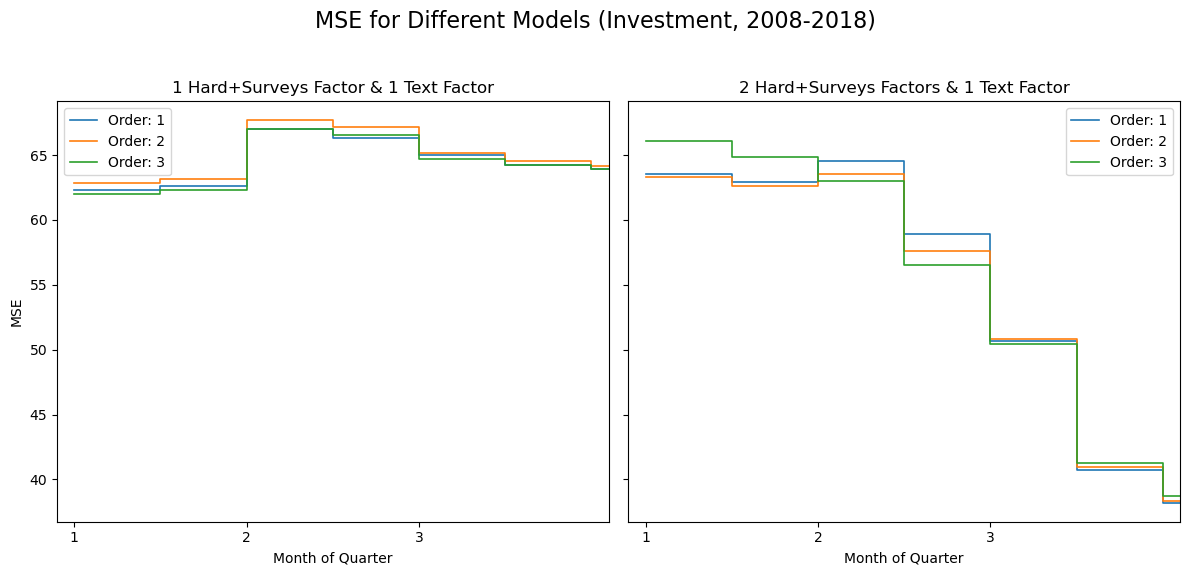

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


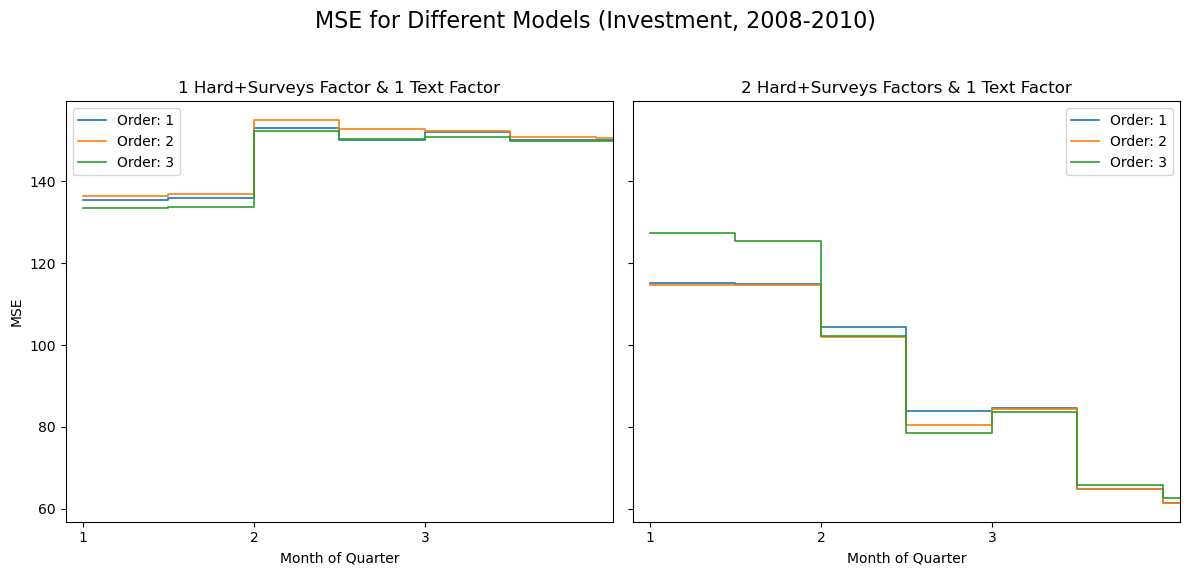

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


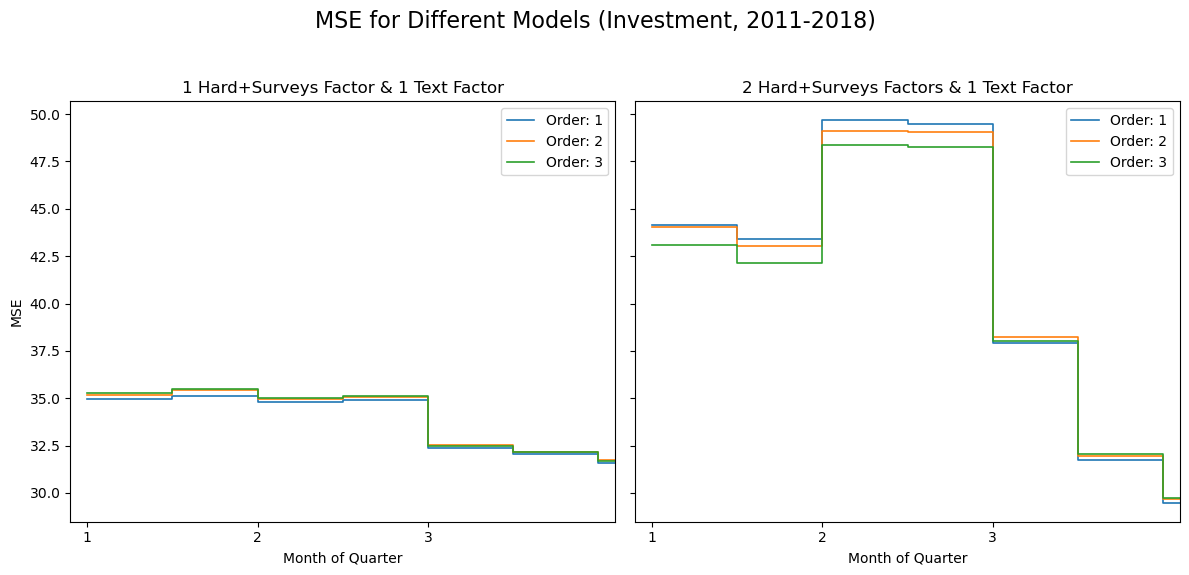

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


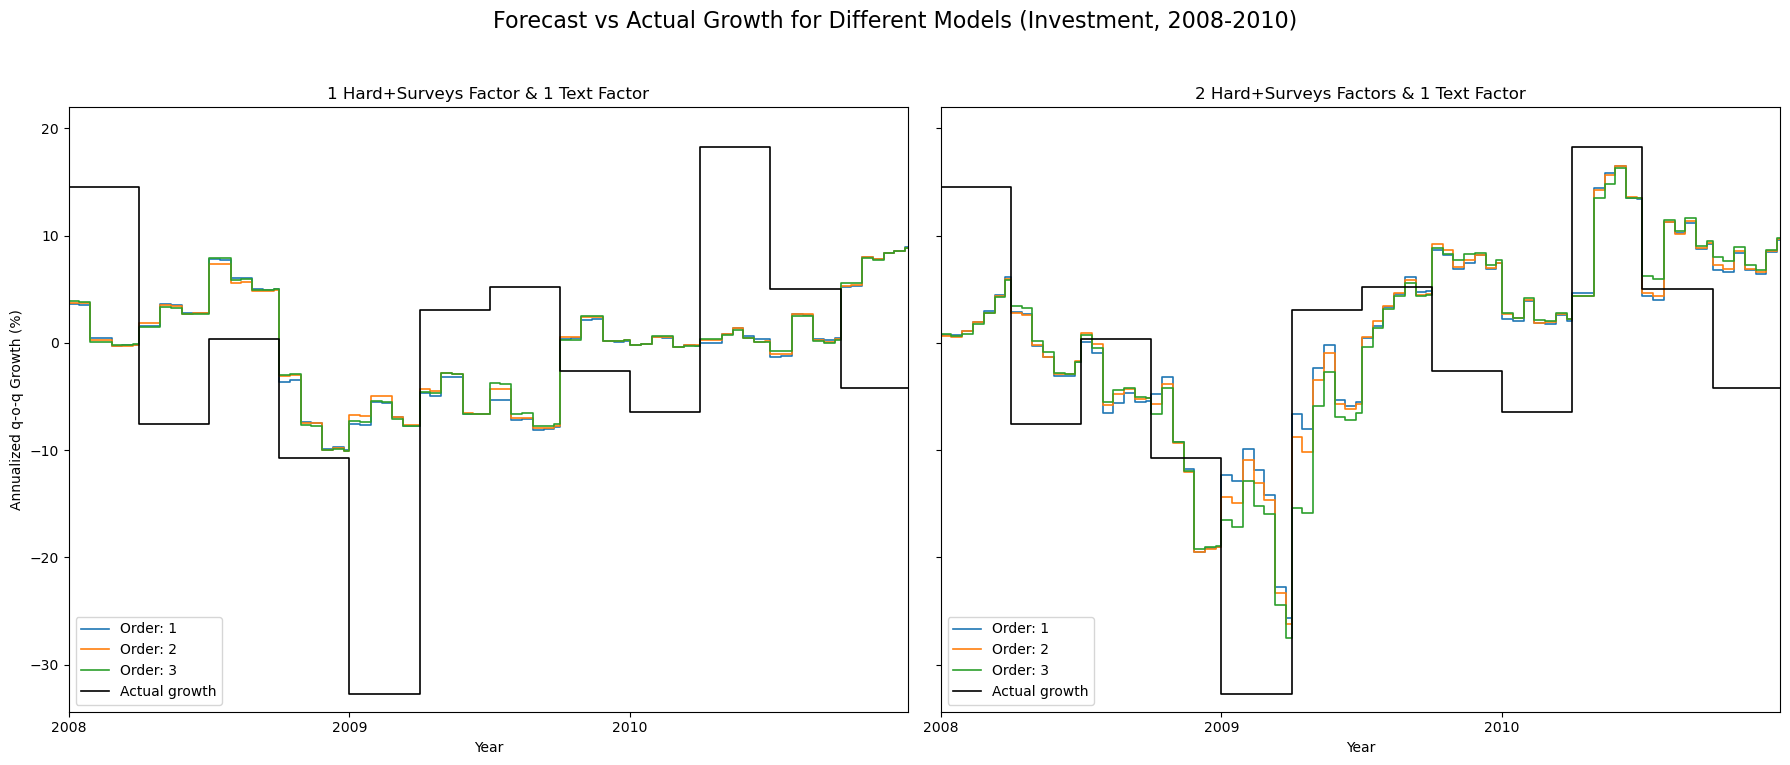

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


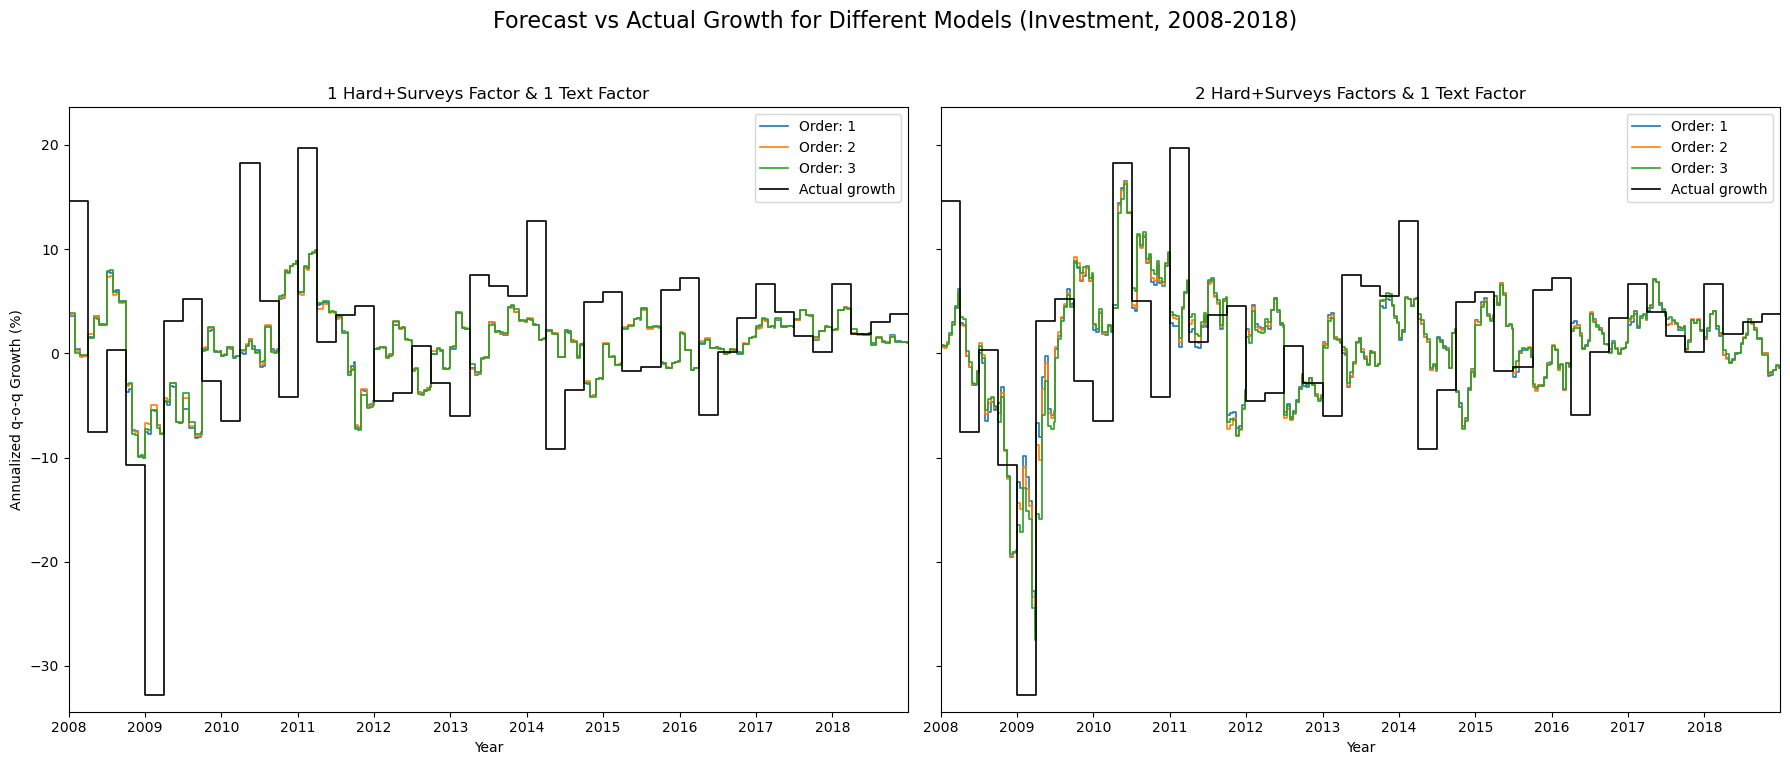

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


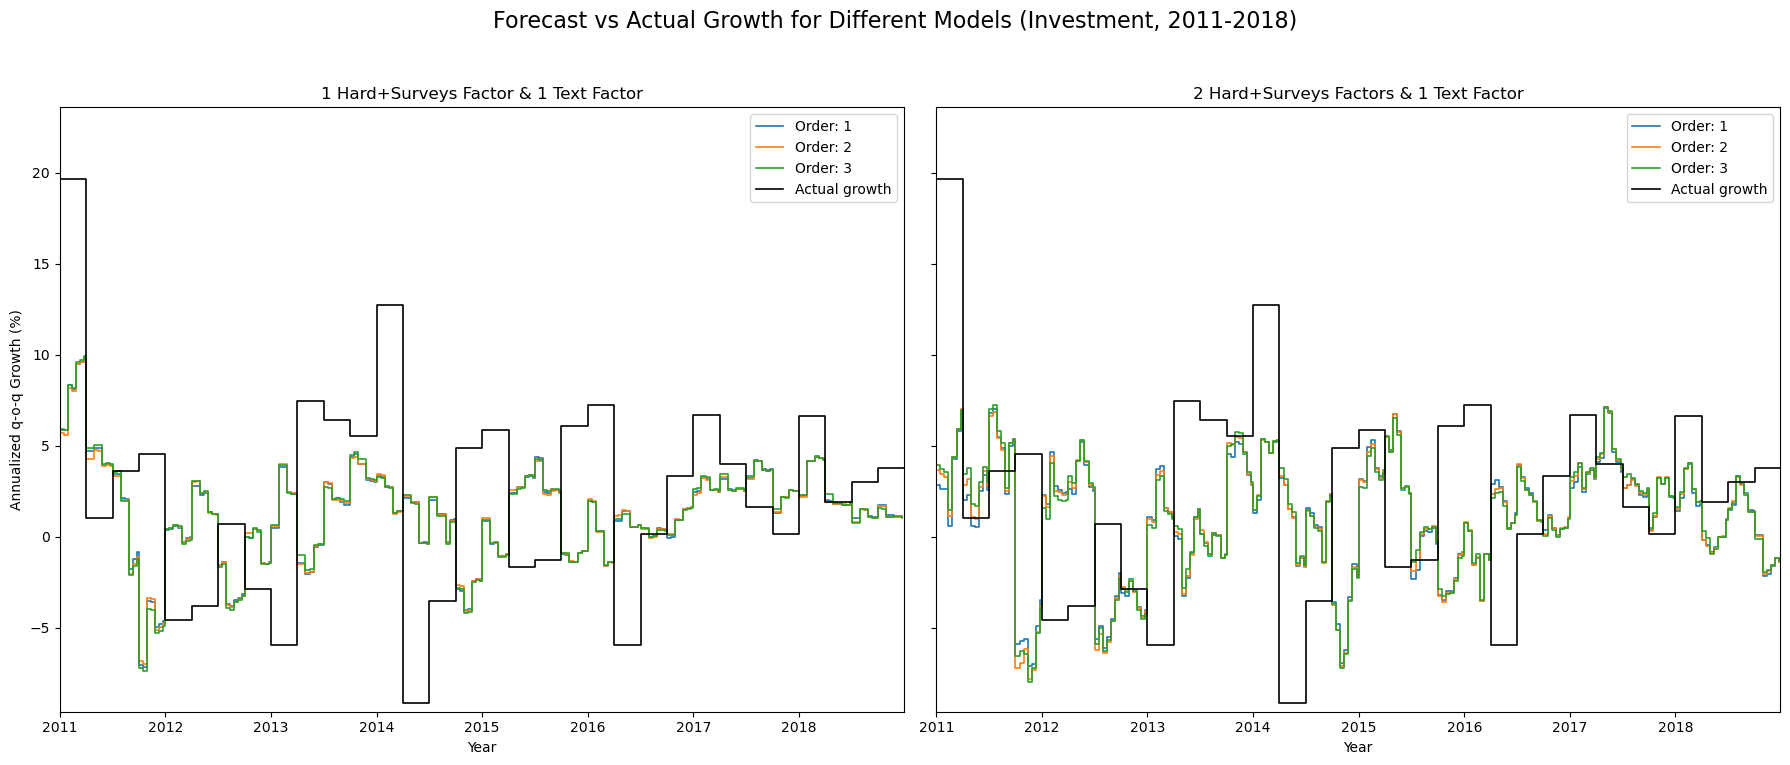

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()